

 # 傅里叶延拓（Fourier Continuation）



 本教程演示了将非周期函数延拓为周期函数的傅里叶延拓方法，该方法可实现高效的谱分析和神经算子应用。

 傅里叶延拓的核心价值在于：

 - 将非周期数据转换为周期形式，适配谱方法的要求

 - 支持在任意域上应用谱方法

 - 提升基于傅里叶的神经算子的收敛性

 - 处理谱计算中的边界条件问题



 教程涵盖了适用于1D、2D、3D数据的两种傅里叶延拓方法：FC-Legendre（勒让德多项式基）和FC-Gram（格拉姆多项式基）。





 ## 导入依赖库

 首先导入`neuralop`库及其他必要的依赖包，包括张量计算、绘图工具和傅里叶延拓核心层。



In [1]:
import torch  # 导入PyTorch，用于张量计算和深度学习操作
import matplotlib.pyplot as plt  # 导入matplotlib绘图库，用于结果可视化
from matplotlib.lines import Line2D  # 导入Line2D，用于自定义图例样式
from neuralop.layers.fourier_continuation import FCLegendre, FCGram  # 导入傅里叶延拓的核心层

# 设置计算设备：优先使用GPU（CUDA），若无则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages




 ## 构建1D非周期函数示例

 我们选取区间 [0,1] 上的函数 f(x) = sin(16x) - cos(8x) 作为测试用例。 该函数在 [0,1] 上不满足周期性，是验证傅里叶延拓效果的理想案例。



In [2]:
length_signal = 101  # 原始1D信号的长度（采样点数）
add_pts = 50  # 延拓时新增的点数（用于扩展信号长度，实现周期延拓）
batch_size = 3  # 批处理大小（同时处理多个信号，模拟批量数据场景）

# 生成1D坐标：在[0,1]区间生成length_signal个均匀采样点，并重复batch_size次（适配批处理）
x = torch.linspace(0, 1, length_signal).repeat(batch_size, 1)
# 定义1D非周期测试函数
f = torch.sin(16 * x) - torch.cos(8 * x)




 ## 信号延拓

 使用FC-Legendre和FC-Gram两种傅里叶延拓层对1D信号进行延拓，将非周期信号转换为周期信号。



In [3]:
# FC-Legendre延拓：基于勒让德多项式基实现傅里叶延拓
# 参数d：多项式基的阶数；n_additional_pts：延拓新增的点数
Extension_Legendre = FCLegendre(d=2, n_additional_pts=add_pts)
# 对信号f进行延拓，dim=1指定延拓的维度（1D信号的维度）
f_extend_Legendre = Extension_Legendre(f, dim=1)

# FC-Gram延拓：基于格拉姆多项式基实现傅里叶延拓
# 参数d：多项式基的阶数；n_additional_pts：延拓新增的点数
Extension_Gram = FCGram(d=4, n_additional_pts=add_pts)
# 对信号f进行延拓，dim=1指定延拓的维度
f_extend_Gram = Extension_Gram(f, dim=1)




 ## 可视化1D傅里叶延拓结果

 绘制原始函数和两种延拓方法的结果，对比其生成光滑周期延拓的效果。



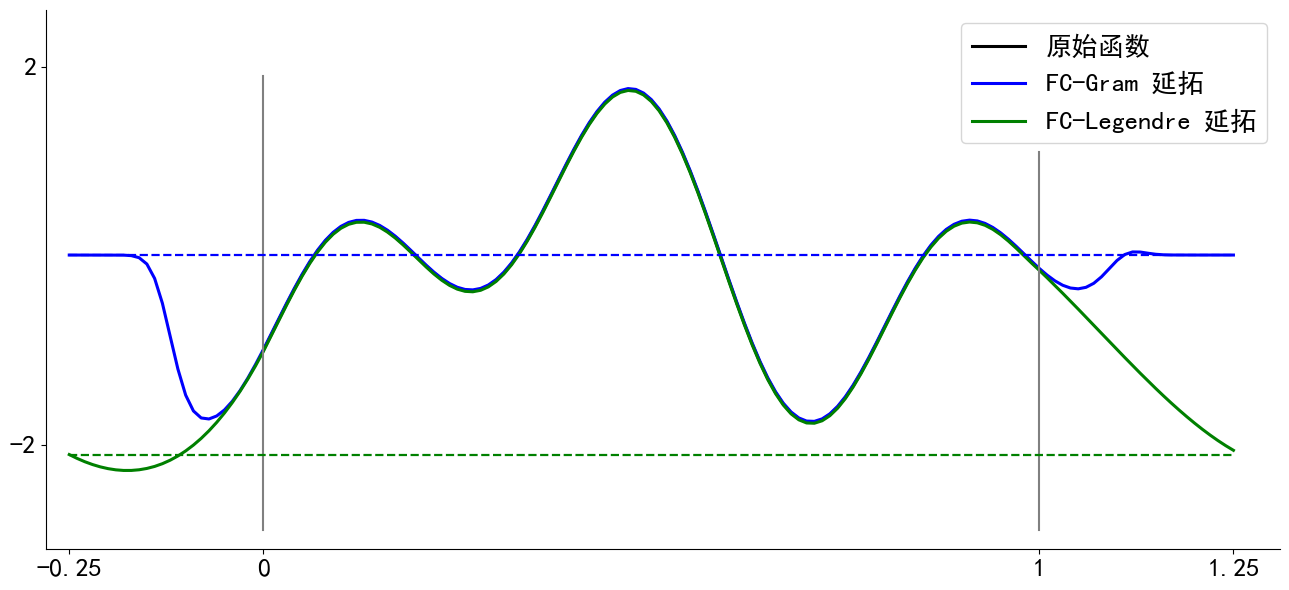

In [4]:
# 生成延拓后的坐标（范围扩展到[-0.25, 1.25]，共151个点，匹配延拓后的信号长度）
x_extended = torch.linspace(-0.25, 1.25, 151)

# 调整延拓函数的纵坐标（仅为可视化区分，避免曲线重叠）
f_extend_Legendre_adjusted = f_extend_Legendre - 0.01
f_extend_Gram_adjusted = f_extend_Gram + 0.01

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 创建绘图窗口，设置尺寸
plt.figure(figsize=(13, 6))
# 绘制原始函数（黑色实线，线宽2.2）
plt.plot(x[0], f[0], "k", label="Original Function", lw=2.2)
# 绘制FC-Gram延拓结果（蓝色实线）
plt.plot(x_extended, f_extend_Gram_adjusted[0], "b", label="FC-Gram Extension", lw=2.2)
# 绘制FC-Legendre延拓结果（绿色实线）
plt.plot(x_extended, f_extend_Legendre_adjusted[0], "g", label="FC-Legendre Extension", lw=2.2)
# 绘制原始区间[0,1]的边界线（灰色实线）
plt.plot([0, 0], [-2.9, 1.9], "-", color="gray", lw=1.5)
plt.plot([1, 1], [-2.9, 1.1], "-", color="gray", lw=1.5)
# 绘制延拓函数的基准线（虚线，便于观察周期性）
plt.plot([-0.25, 1.25], [f_extend_Legendre_adjusted[0, 0], f_extend_Legendre_adjusted[0, 0]], "--", color="g", lw=1.6)
plt.plot([-0.25, 1.25], [f_extend_Gram_adjusted[0, 0], f_extend_Gram_adjusted[0, 0]], "--", color="b", lw=1.6)

# 自定义图例样式（解决标签重叠/样式统一问题）
legend_elements = [
    Line2D([0], [0], color="k", lw=2.2, label="原始函数"),
    Line2D([0], [0], color="b", lw=2.2, label="FC-Gram 延拓"),
    Line2D([0], [0], color="g", lw=2.2, label="FC-Legendre 延拓"),
]
# 添加图例，设置字体大小
legend = plt.legend(handles=legend_elements, fontsize=19)
# 设置x轴和y轴范围（优化可视化效果）
plt.xlim([-0.28, 1.31])
plt.ylim([-3.1, 2.6])
# 获取当前坐标轴对象，调整样式
ax = plt.gca()
ax.spines["top"].set_visible(False)  # 隐藏顶部边框
ax.spines["right"].set_visible(False)  # 隐藏右侧边框
ax.tick_params(axis="x", which="major", labelsize=19)  # 设置x轴刻度字体大小
ax.tick_params(axis="y", which="major", labelsize=19)  # 设置y轴刻度字体大小
plt.xticks([-0.25, 0, 1, 1.25], ["-0.25", "0", "1", "1.25"])  # 自定义x轴刻度
plt.yticks([-2, 2])  # 自定义y轴刻度
plt.tight_layout()  # 自动调整布局，避免元素重叠
plt.show()  # 显示图像




 ## 构建2D非周期函数示例

 选取单位正方形域 [0,1]×[0,1] 上的函数 f(x,y) = sin(12x) - cos(14y) + 3xy 作为测试用例。

 该函数在单位正方形上不满足周期性，适合验证2D傅里叶延拓方法。



In [5]:
length_signal = 101  # 2D信号每个维度的长度（采样点数）
add_pts = 50  # 每个维度延拓新增的点数
batch_size = 3  # 批处理大小

# 生成2D坐标网格：
# x：形状为(batch_size, length_signal, length_signal)，沿第一个维度采样
x = torch.linspace(0, 1, length_signal).view(1, length_signal, 1).repeat(batch_size, 1, length_signal)
# y：形状为(batch_size, length_signal, length_signal)，沿第二个维度采样
y = torch.linspace(0, 1, length_signal).view(1, 1, length_signal).repeat(batch_size, length_signal, 1)

# 定义2D非周期测试函数
f = torch.sin(12 * x) - torch.cos(14 * y) + 3 * x * y




 ## 2D信号延拓

 使用FC-Legendre和FC-Gram层对2D信号进行延拓，生成光滑的2D周期延拓结果。



In [6]:
# FC-Legendre 2D延拓：d=3为多项式基阶数，n_additional_pts为每个维度新增点数
Extension_Legendre = FCLegendre(d=3, n_additional_pts=add_pts)
# dim=2指定对2D信号的第二个维度（y轴）开始延拓（实际会遍历2D的两个维度）
f_extend_Legendre = Extension_Legendre(f, dim=2)

# FC-Gram 2D延拓：参数与FC-Legendre一致
Extension_Gram = FCGram(d=3, n_additional_pts=add_pts)
f_extend_Gram = Extension_Gram(f, dim=2)




 ## 可视化2D傅里叶延拓结果

 绘制原始函数和两种延拓方法的结果，黑色线条标记原始域（单位正方形）的边界，对比延拓效果。



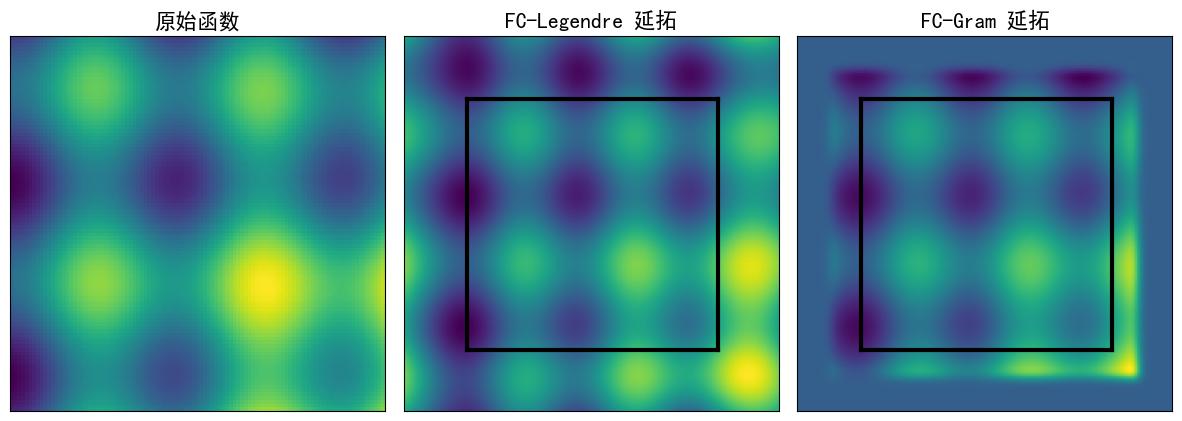

In [7]:
# 创建1行3列的子图，设置总尺寸
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

# 绘制原始2D函数（第一个子图）
axs[0].imshow(f[0])
axs[0].set_title(r"原始函数", fontsize=15.5)

# 绘制FC-Legendre延拓结果（第二个子图）
axs[1].imshow(f_extend_Legendre[0])
# 绘制原始域的边界线（黑色实线，线宽3）
axs[1].plot([add_pts//2, length_signal + add_pts//2], [add_pts//2, add_pts//2], "-", color="k", lw=3)  # 上边界
axs[1].plot([add_pts//2, add_pts//2], [add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)  # 左边界
axs[1].plot([add_pts//2, length_signal + add_pts//2], [length_signal + add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)  # 下边界
axs[1].plot([length_signal + add_pts//2, length_signal + add_pts//2], [add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)  # 右边界
axs[1].set_title(r"FC-Legendre 延拓", fontsize=15.5)

# 绘制FC-Gram延拓结果（第三个子图）
axs[2].imshow(f_extend_Gram[0])
# 绘制原始域的边界线
axs[2].plot([add_pts//2, length_signal + add_pts//2], [add_pts//2, add_pts//2], "-", color="k", lw=3)
axs[2].plot([add_pts//2, add_pts//2], [add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)
axs[2].plot([add_pts//2, length_signal + add_pts//2], [length_signal + add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)
axs[2].plot([length_signal + add_pts//2, length_signal + add_pts//2], [add_pts//2, length_signal + add_pts//2], "-", color="k", lw=3)
axs[2].set_title(r"FC-Gram 延拓", fontsize=15.5)

# 隐藏所有子图的刻度（简化可视化）
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05)  # 减小子图间的空白
plt.show()  # 显示图像




 ## 构建3D非周期函数示例

 选取单位立方体域 [0,1]×[0,1]×[0,1] 上的函数：

 f(x,y,z) = exp(-2z) + 2xz + sin(12xy) + y sin(10yz)

 该函数在单位立方体上不满足周期性，用于验证3D傅里叶延拓效果。



In [8]:
batch_size = 2  # 批处理大小（3D数据计算量较大，减小批次）
length_signal = 101  # 3D信号每个维度的长度
add_pts = 50  # 每个维度延拓新增的点数

# 生成3D坐标网格：
# x：形状为(batch_size, length_signal, length_signal, length_signal)，沿第一个维度采样
x = torch.linspace(0, 1, length_signal).view(1, length_signal, 1, 1).repeat(batch_size, 1, length_signal, length_signal)
# y：沿第二个维度采样
y = torch.linspace(0, 1, length_signal).view(1, 1, length_signal, 1).repeat(batch_size, length_signal, 1, length_signal)
# z：沿第三个维度采样
z = torch.linspace(0, 1, length_signal).view(1, 1, 1, length_signal).repeat(batch_size, length_signal, length_signal, 1)

# 定义3D非周期测试函数
f = torch.exp(-2 * z) + 2 * z * x + torch.sin(12 * x * y) + y * torch.sin(10 * y * z)




 ## 3D信号延拓

 使用FC-Legendre和FC-Gram层对3D信号进行延拓，生成3D周期延拓结果。



In [9]:
# FC-Legendre 3D延拓：d=3为多项式基阶数
Extension_Legendre = FCLegendre(d=3, n_additional_pts=add_pts)
f_extend_Legendre = Extension_Legendre(f, dim=3)  # dim=3指定3D信号延拓

# FC-Gram 3D延拓
Extension_Gram = FCGram(d=3, n_additional_pts=add_pts)
f_extend_Gram = Extension_Gram(f, dim=3)




 ## 可视化3D傅里叶延拓结果

 通过切片（X/Y/Z方向）展示3D延拓效果，白色线条标记原始3D域的边界。

 首先统一所有图像的颜色范围（确保对比公平）。



In [10]:
# 计算原始函数和延拓函数的极值（用于统一颜色映射范围）
f_min = f.min().item()  # 原始函数最小值
f_max = f.max().item()  # 原始函数最大值
f_ext_legendre_min = f_extend_Legendre.min().item()  # FC-Legendre延拓最小值
f_ext_legendre_max = f_extend_Legendre.max().item()  # FC-Legendre延拓最大值
f_ext_gram_min = f_extend_Gram.min().item()  # FC-Gram延拓最小值
f_ext_gram_max = f_extend_Gram.max().item()  # FC-Gram延拓最大值

# 全局极值：用于统一所有图像的颜色范围
global_min = min(f_min, f_ext_legendre_min, f_ext_gram_min)
global_max = max(f_max, f_ext_legendre_max, f_ext_gram_max)




 ### X方向切片可视化

 选取X维度的三个切片（1/4、1/2、3/4位置），对比原始函数和两种延拓方法的结果。



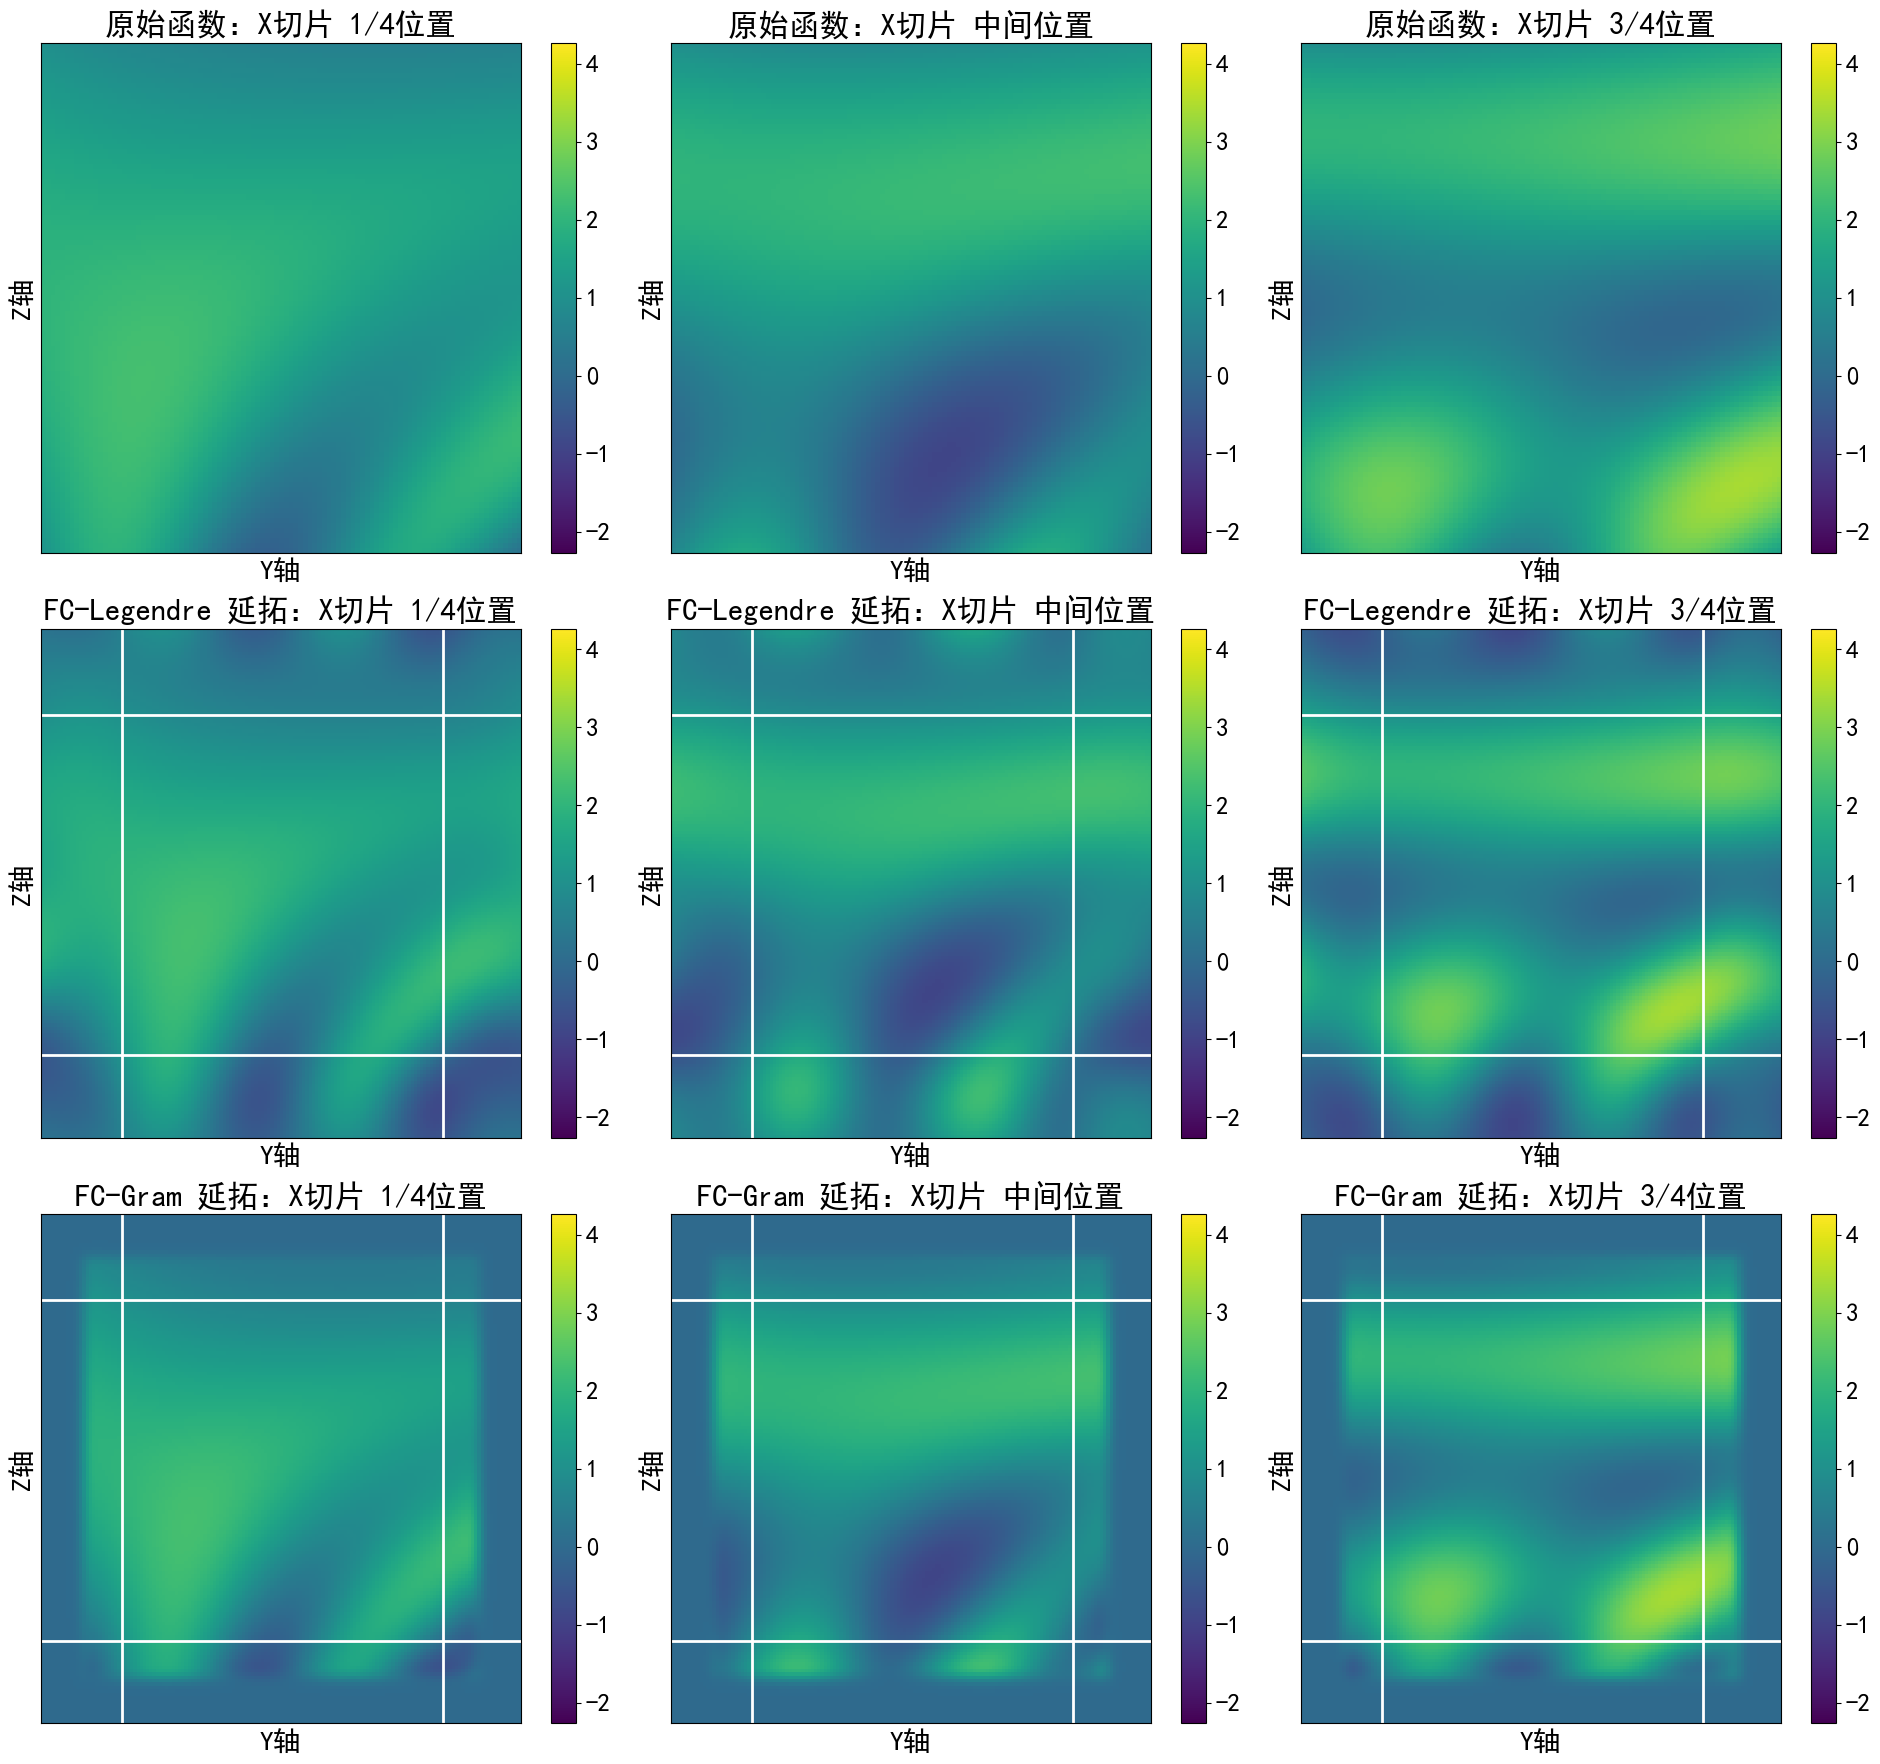

In [11]:
# 创建绘图窗口，设置尺寸
fig = plt.figure(figsize=(24, 20))
# 选取X维度的切片索引（1/4、1/2、3/4位置）
slice_indices = [length_signal//4, length_signal//2, 3*length_signal//4]
# 切片名称（用于标题）
slice_names = ["1/4位置", "中间位置", "3/4位置"]

for i, (idx, name) in enumerate(zip(slice_indices, slice_names)):
    # 1. 绘制原始函数的X切片（第一行子图）
    ax = fig.add_subplot(3, 3, i + 1)
    # 绘制切片：取第0个批次、X维度idx位置的切片，颜色映射为viridis，范围为全局极值
    im = ax.imshow(f[0, idx, :, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"原始函数：X切片 {name}", fontsize=22, fontweight="bold")  # 设置标题
    ax.set_xlabel("Y轴", fontsize=20)  # X轴对应原始数据的Y维度
    ax.set_ylabel("Z轴", fontsize=20)  # Y轴对应原始数据的Z维度
    ax.set_xticks([])  # 隐藏刻度
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)  # 添加颜色条
    cbar.ax.tick_params(labelsize=18)  # 设置颜色条刻度字体大小

    # 2. 绘制FC-Legendre延拓的X切片（第二行子图）
    ax = fig.add_subplot(3, 3, i + 4)
    ext_idx = idx + add_pts//2  # 延拓后切片的索引（新增点数均分在两侧）
    im = ax.imshow(f_extend_Legendre[0, ext_idx, :, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Legendre 延拓：X切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("Y轴", fontsize=20)
    ax.set_ylabel("Z轴", fontsize=20)
    # 绘制原始域的边界线（白色实线，线宽2）
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")  # Z轴下边界
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")  # Z轴上边界
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")  # Y轴左边界
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")  # Y轴右边界
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

    # 3. 绘制FC-Gram延拓的X切片（第三行子图）
    ax = fig.add_subplot(3, 3, i + 7)
    im = ax.imshow(f_extend_Gram[0, ext_idx, :, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Gram 延拓：X切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("Y轴", fontsize=20)
    ax.set_ylabel("Z轴", fontsize=20)
    # 绘制原始域的边界线
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

# 调整子图布局（减小间距，顶部留空）
plt.subplots_adjust(hspace=0.15, wspace=0.05, top=0.95)
plt.show()




 ### Y方向切片可视化

 选取Y维度的三个切片（1/4、1/2、3/4位置），对比原始函数和两种延拓方法的结果。



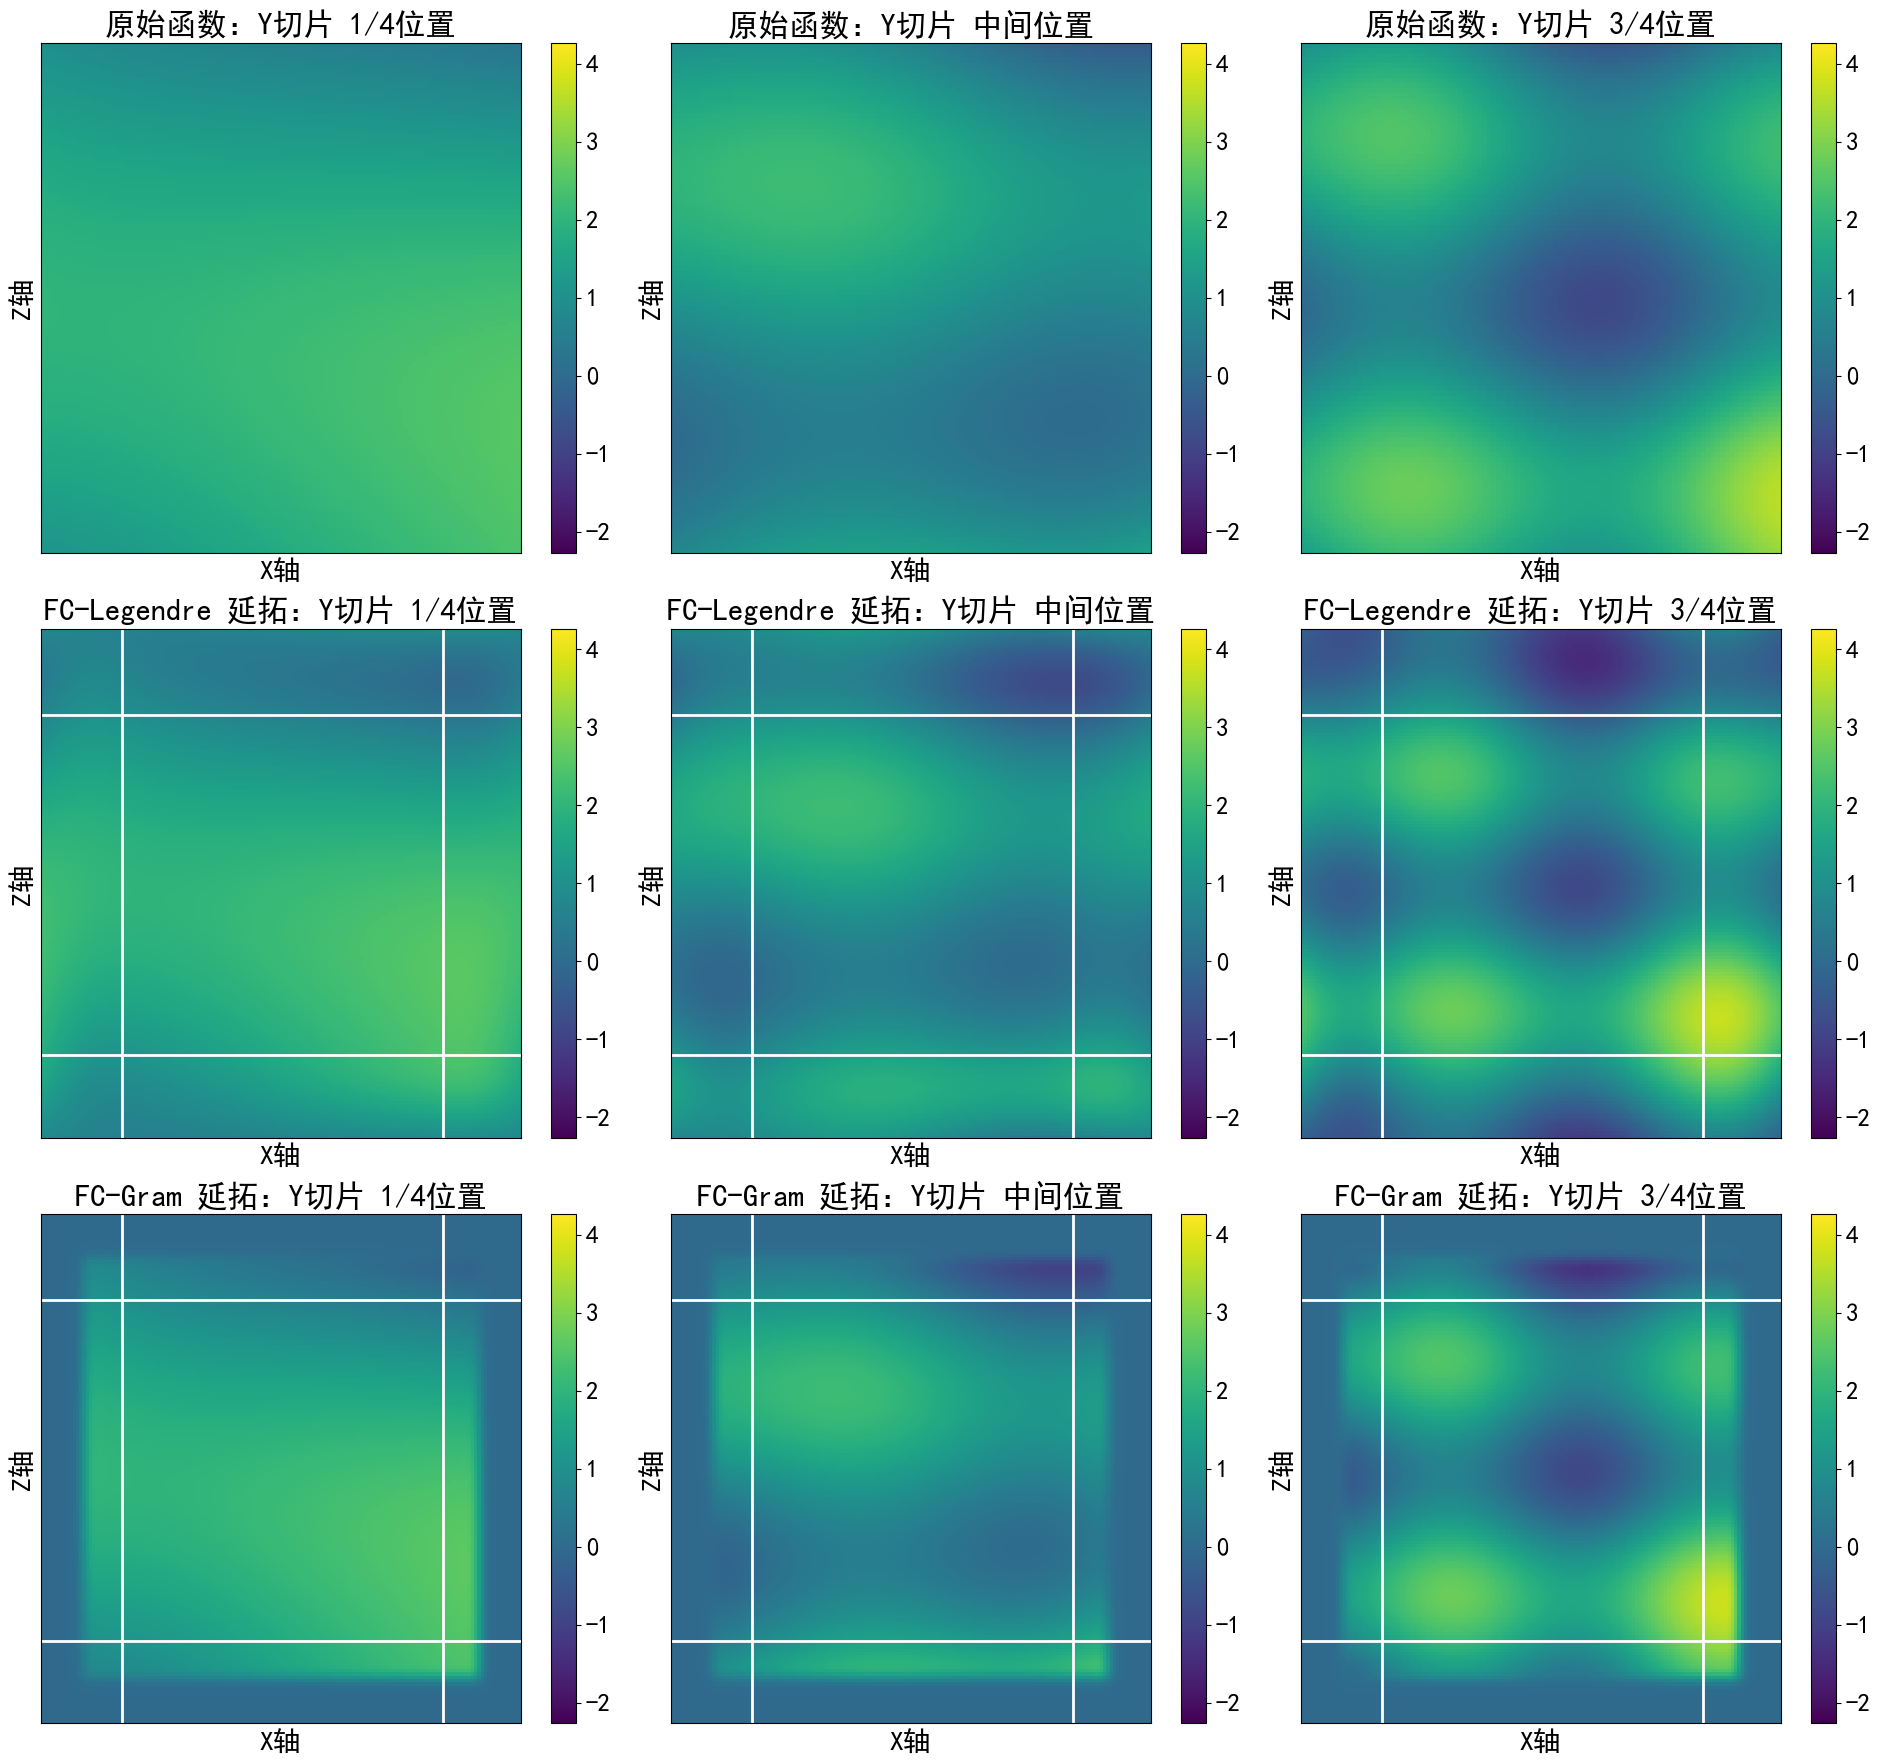

In [12]:
fig2 = plt.figure(figsize=(24, 20))

for i, (idx, name) in enumerate(zip(slice_indices, slice_names)):
    # 1. 绘制原始函数的Y切片（第一行子图）
    ax = fig2.add_subplot(3, 3, i + 1)
    im = ax.imshow(f[0, :, idx, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"原始函数：Y切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)  # X轴对应原始数据的X维度
    ax.set_ylabel("Z轴", fontsize=20)  # Y轴对应原始数据的Z维度
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

    # 2. 绘制FC-Legendre延拓的Y切片（第二行子图）
    ax = fig2.add_subplot(3, 3, i + 4)
    ext_idx = idx + add_pts//2  # 延拓后切片的索引
    im = ax.imshow(f_extend_Legendre[0, :, ext_idx, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Legendre 延拓：Y切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)
    ax.set_ylabel("Z轴", fontsize=20)
    # 绘制原始域的边界线
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

    # 3. 绘制FC-Gram延拓的Y切片（第三行子图）
    ax = fig2.add_subplot(3, 3, i + 7)
    im = ax.imshow(f_extend_Gram[0, :, ext_idx, :].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Gram 延拓：Y切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)
    ax.set_ylabel("Z轴", fontsize=20)
    # 绘制原始域的边界线
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

plt.subplots_adjust(hspace=0.15, wspace=0.05, top=0.95)
plt.show()




 ### Z方向切片可视化

 选取Z维度的三个切片（1/4、1/2、3/4位置），对比原始函数和两种延拓方法的结果。



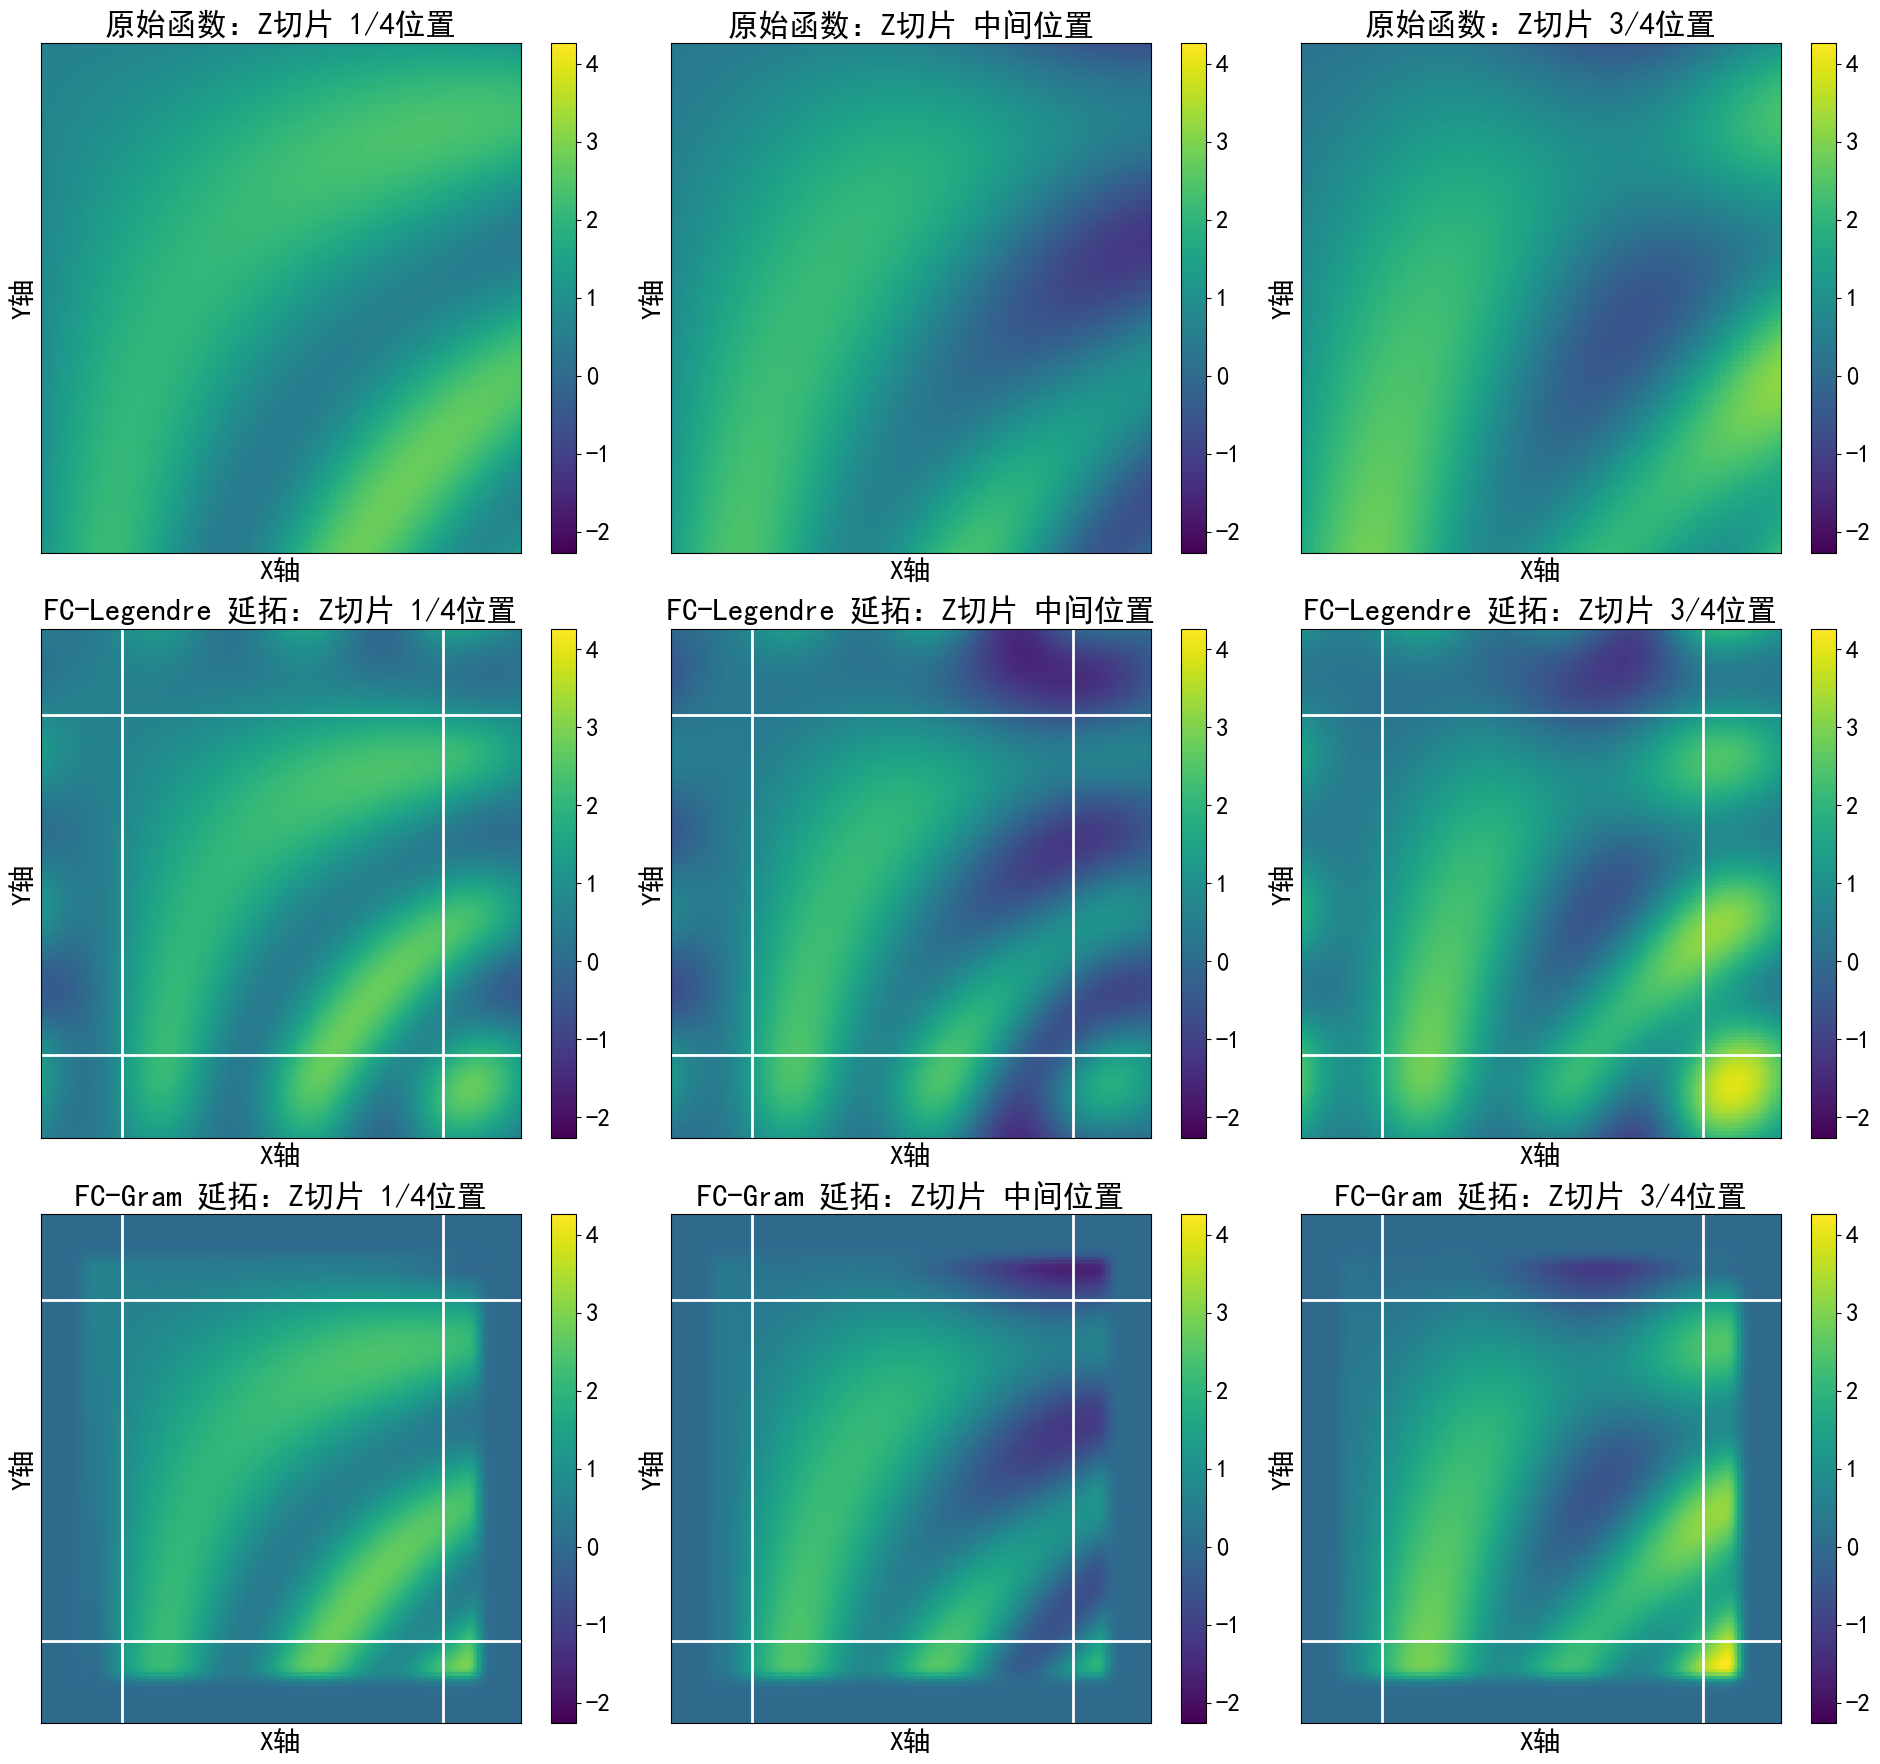

In [13]:
fig3 = plt.figure(figsize=(24, 20))

for i, (idx, name) in enumerate(zip(slice_indices, slice_names)):
    # 1. 绘制原始函数的Z切片（第一行子图）
    ax = fig3.add_subplot(3, 3, i + 1)
    im = ax.imshow(f[0, :, :, idx].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"原始函数：Z切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)  # X轴对应原始数据的X维度
    ax.set_ylabel("Y轴", fontsize=20)  # Y轴对应原始数据的Y维度
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

    # 2. 绘制FC-Legendre延拓的Z切片（第二行子图）
    ax = fig3.add_subplot(3, 3, i + 4)
    ext_idx = idx + add_pts//2  # 延拓后切片的索引
    im = ax.imshow(f_extend_Legendre[0, :, :, ext_idx].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Legendre 延拓：Z切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)
    ax.set_ylabel("Y轴", fontsize=20)
    # 绘制原始域的边界线
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

    # 3. 绘制FC-Gram延拓的Z切片（第三行子图）
    ax = fig3.add_subplot(3, 3, i + 7)
    im = ax.imshow(f_extend_Gram[0, :, :, ext_idx].numpy(), cmap="viridis", aspect="auto", vmin=global_min, vmax=global_max)
    ax.set_title(f"FC-Gram 延拓：Z切片 {name}", fontsize=22, fontweight="bold")
    ax.set_xlabel("X轴", fontsize=20)
    ax.set_ylabel("Y轴", fontsize=20)
    # 绘制原始域的边界线
    ax.axhline(y=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axhline(y=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.axvline(x=length_signal + add_pts//2, color="white", linewidth=2, linestyle="-")
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)

plt.subplots_adjust(hspace=0.15, wspace=0.05, top=0.95)
plt.show()